# Creating an example of a circuit cost function

In [1]:
from qiskit.circuit import QuantumCircuit
from qiskit_aer import AerSimulator
from qiskit.visualization import plot_histogram
from random import randrange
from numpy import pi
from project.unified_noise_model.Unified_Noise_Model import Unified_Noise_Model

### First cost function

   Create a cost function for $Q$ number of qubits. The circuit of the cost function must be $I$ iterations of pairs of $rz$ gates. That means, if $I=3$, there sould be $2*3=6$ $rz$ gates per qubit. It also need a noise model as parameter. This noise model will affect the result of running the $rz$'s circuit. The cost is calculated as the sum of each qubit average result. Considering that we run the circuit $10000$, if we measure $6000$ times $0$ an the other $4000$ we measure $1$ in the first qubit, this qubit will have an average value of $0.6$. We repeat this process for each of the rest qubits and calculate the sum. The cost will be value between $0$ and $Q$

NoiseModel:
  Basis gates: ['cx', 'id', 'rz', 'sx']
  Instructions with noise: ['rz']
  All-qubits errors: ['rz']


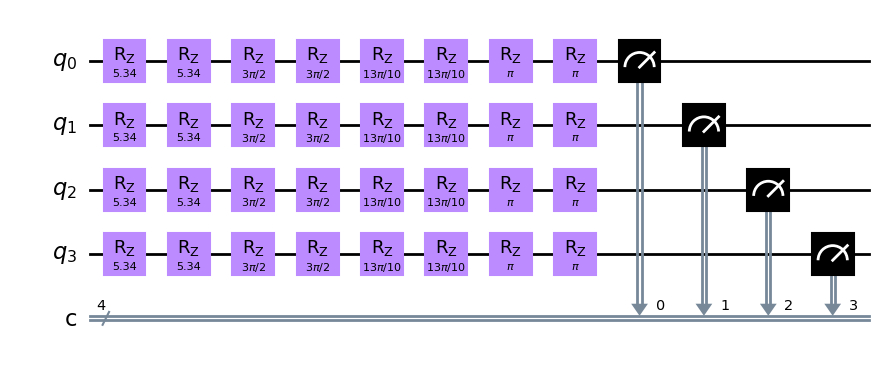

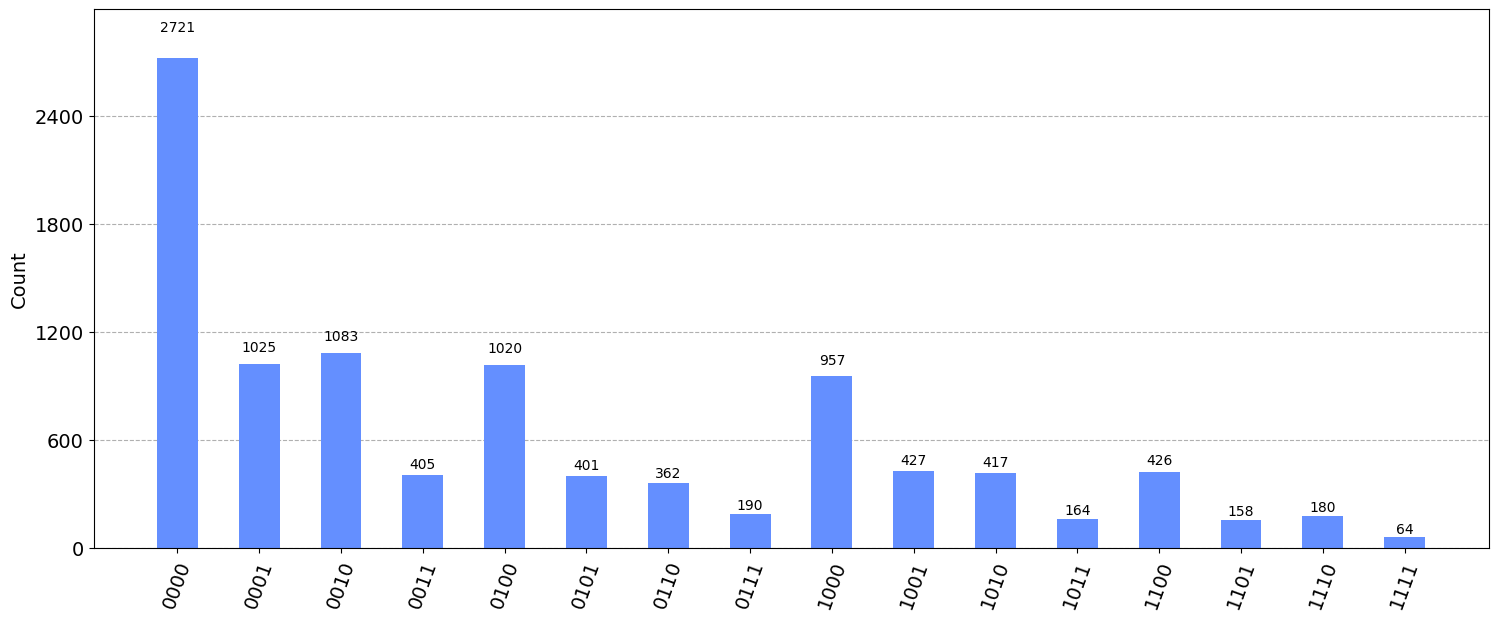

qubit  0  average: 0.2793 

qubit  1  average: 0.2801 

qubit  2  average: 0.2865 

qubit  3  average: 0.2834 

cost: 1.1293 



In [2]:
def cost_func(num_qubits,num_iterations,noise_model):
    qc = QuantumCircuit(num_qubits,num_qubits)
    shots=10000
    
    #Add random phi cz gates
    for itr in range(num_iterations):
        random_phi = randrange(0,20,step=1)
        random_phi = random_phi / 10
        for q in range(num_qubits):
            qc.rz(random_phi * pi,q)
            qc.rz(random_phi * pi,q)
            
    qc.measure(range(num_qubits),range(num_qubits))
    display(qc.draw('mpl'))
    
    #Run the circuit 10000 times and store the results
    simulator = AerSimulator(noise_model=noise_model)
    result = simulator.run(qc,shots=shots).result()
    counts = result.get_counts(0)
    display(plot_histogram(counts,figsize=[18,7]))

    #Calculate the average for result of each qubit, and finally sum each of the averages to get the COST.
    cost = 0
    for qubit in range(num_qubits):
        qubit_average = 0
        for string in counts.keys():
            current_qubit_in_current_string = string[qubit]
            if current_qubit_in_current_string == '1':
                qubit_average += counts[string]
        qubit_average = qubit_average / shots
        print('qubit ',qubit,' average:',qubit_average,'\n')
        cost += qubit_average
    return cost
                
unm = Unified_Noise_Model()
#noise model with 0.2 of depolarization prob
unm.add_depolarizing_channel(0.1,['rz'],[])
print(unm.noise_model)

#cost function with 5 qubits and 4 iterations
cost = cost_func(4,4,unm.noise_model) 
print('cost:',cost,'\n')


### Second cost function

Given a cost function with a fixed...
* amount of rz pairs iterations
* noise level
* amount of qubits

...find the rz rotations that minimize the cost. 

* First of all, do it just with depolarizing noise. 

In [127]:
def cost_func2(rotations,num_qubits,num_iterations,noise_model):
    qc = QuantumCircuit(num_qubits,num_qubits)
    shots=10000
    
    #Add random phi cz gates
    for itr in range(num_iterations):
        for q in range(num_qubits):
            qc.rz(rotations[itr],q)
            qc.rz(rotations[itr],q)
            
    qc.measure(range(num_qubits),range(num_qubits))
    #display(qc.draw('mpl'))
    
    #Run the circuit 10000 times and store the results
    simulator = AerSimulator(noise_model=noise_model)
    result = simulator.run(qc,shots=shots).result()
    counts = result.get_counts(0)
    #display(plot_histogram(counts,figsize=[18,7]))

    #Calculate the average for result of each qubit, and finally sum each of the averages to get the COST.
    cost = 0
    for qubit in range(num_qubits):
        qubit_average = 0
        for string in counts.keys():
            current_qubit_in_current_string = string[qubit]
            if current_qubit_in_current_string == '1':
                qubit_average += counts[string]
        qubit_average = qubit_average / shots
        #print('qubit ',qubit,' average:',qubit_average,'\n')
        cost += qubit_average
    cost = cost
    #print('cost ',cost)
    #print('---------------------------------------------')
    costs.append(cost)
    return cost

In [123]:
from scipy.optimize import minimize
costs = []

# setting up the fixed parameters
depol_noise_prob = 0.5
num_iterations = 4
num_qubits = 4

#noise model
unm = Unified_Noise_Model()
unm.add_depolarizing_channel(depol_noise_prob,['rz'],[])
print(unm.noise_model)

#cost function

#There are the multipl
angles = []
for i in range(num_iterations):
    random_phi = randrange(0,20,step=1)
    random_phi = random_phi / 10
    angles.append(random_phi * pi)

print('angles:', angles)

result = minimize(
fun=cost_func2,
x0=angles,
args=(num_qubits,num_iterations,unm.noise_model),
method='L-BFGS-B',
)

print('result: ',result)
print('checking minimized parameters:')
cost = cost_func2(result.x,num_qubits,num_iterations,unm.noise_model)
print(cost)

NoiseModel:
  Basis gates: ['cx', 'id', 'rz', 'sx']
  Instructions with noise: ['rz']
  All-qubits errors: ['rz']
angles: [4.71238898038469, 0.6283185307179586, 3.141592653589793, 2.5132741228718345]
result:    message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
  success: True
   status: 0
      fun: 1.9957
        x: [ 4.712e+00  6.283e-01  3.142e+00  2.513e+00]
      nit: 2
      jac: [ 1.250e+06  3.000e+05 -3.000e+04 -8.900e+05]
     nfev: 110
     njev: 22
 hess_inv: <4x4 LbfgsInvHessProduct with dtype=float64>
checking minimized parameters:
1.992


Text(0, 0.5, 'cost')

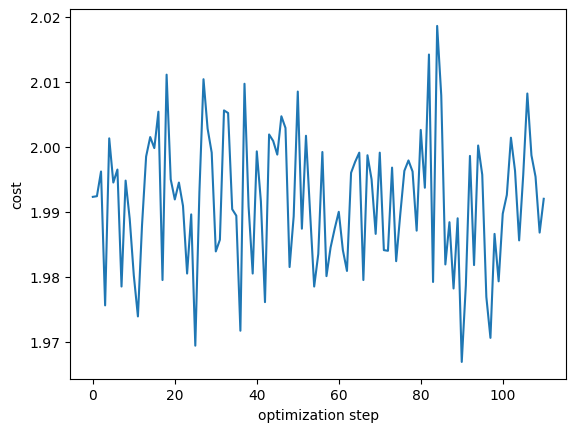

In [124]:
import matplotlib.pyplot as plt

#print(costs)
plt.plot(range(len(costs)),costs, label='Cost Function')
plt.xlabel('optimization step')
plt.ylabel('cost')

* Second, try varying the depolarizing noise level and compare the minimized parameters.


In [125]:
from scipy.optimize import minimize

all_costs = []
all_min_costs = []

# setting up the fixed parameters
depol_noise_prob = 0.5
num_iterations = 4
num_qubits = 4

#Setting up the random angles to optimize
angles = []
for i in range(num_iterations):
    random_phi = randrange(0,20,step=1)
    random_phi = random_phi / 10
    angles.append(random_phi * pi)
print('angles:', angles)

#Repeat the optimization for different noise level
for prob in range(0,55,5):
    print('---------------------------------------------')
    print('--------------------error prob ',prob/100,'--------------------')
    print('---------------------------------------------')
    
    #defining local iteration variables
    costs = []
    depol_noise_prob = prob / 100

    #noise model
    unm = Unified_Noise_Model()
    unm.add_depolarizing_channel(depol_noise_prob,['rz'],[])
    print(unm.noise_model)

    #cost function
    result = minimize(
    fun=cost_func2,
    x0=angles,
    args=(num_qubits,num_iterations,unm.noise_model),
    method='L-BFGS-B',
    )
    print('result: ',result)
    
    print('checking minimized parameters:')
    min_cost = cost_func2(result.x,num_qubits,num_iterations,unm.noise_model)
    print(min_cost)
    
    #saving the costs of this sumulation
    all_costs.append(costs)
    
    all_min_costs.append(min_cost)

angles: [1.5707963267948966, 2.199114857512855, 1.5707963267948966, 5.340707511102648]
---------------------------------------------
--------------------prob  0.0 --------------------
---------------------------------------------
NoiseModel: Ideal
result:    message: CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL
  success: True
   status: 0
      fun: 0.0
        x: [ 1.571e+00  2.199e+00  1.571e+00  5.341e+00]
      nit: 0
      jac: [ 0.000e+00  0.000e+00  0.000e+00  0.000e+00]
     nfev: 5
     njev: 1
 hess_inv: <4x4 LbfgsInvHessProduct with dtype=float64>
checking minimized parameters:
0.0
---------------------------------------------
--------------------prob  0.05 --------------------
---------------------------------------------
NoiseModel:
  Basis gates: ['cx', 'id', 'rz', 'sx']
  Instructions with noise: ['rz']
  All-qubits errors: ['rz']
result:    message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
  success: True
   status: 0
      fun: 0.6787000000000001
        x:

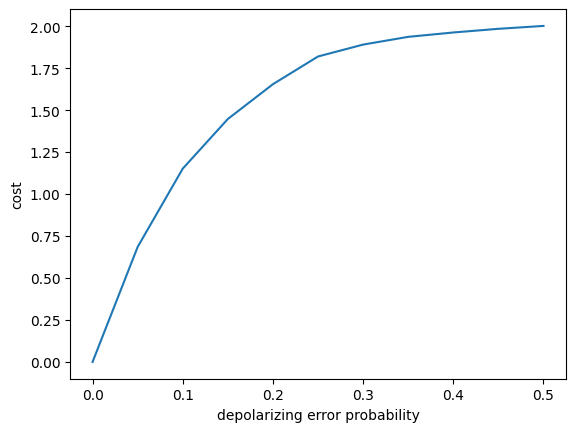

In [126]:
#print(all_min_costs)
plt.xlabel('depolarizing error probability')
plt.ylabel('cost')
plt.plot([0,0.05,0.1,0.15,0.2,0.25,0.3,0.35,0.4,0.45,0.5],all_min_costs, label='Cost Function')


* Finally, try it with the complete UNM model